# Data analysis
Hello, welcome!

This notebook is meant to help you read in Qualtrics survey data. The notebook, however, is quite specific and geared to analyzing the specific data we gathered for my internship research. Nonetheless, some of the code and ideas might still be useful for other purposes.

## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import csv
import seaborn as sns

## Read in data
This section is about reading in the data file into pandas dataframe format. Note: the data should be download in _t_sv (tab separated file) format rather than _c_sv format (comma separated file). This is because commas can be confusing, for example if you used them in your questions. 

In [2]:
# Change this variable if you use another filename
filename = "surveydatafinal.tsv"

In [3]:
# Code to collect the headers
df_old = pd.read_csv(filename, dtype=str, sep='\t', encoding='utf-16')
headers = df_old.columns
print(headers)

Index(['StartDate', 'EndDate', 'Status', 'Progress', 'Duration (in seconds)',
       'Finished', 'RecordedDate', 'ResponseId', 'DistributionChannel',
       'UserLanguage',
       ...
       '96_QuestionList2_1', '97_QuestionList2_1', '98_QuestionList2_1',
       '99_QuestionList2_1', '100_QuestionList2_1', '101_QuestionList2_1',
       '102_QuestionList2_1', 'Goal_experiment', 'Goal_experiment_2_TEXT',
       'id'],
      dtype='object', length=218)


In [4]:
with open(filename, mode ='r' , encoding='utf-16')as file:
   
    # reading the CSV file
    csvFile = csv.reader(file, delimiter ='\t')
    df = pd.DataFrame(data = csvFile)
    
# We drop the first few rows because they contain information that is not relevant to what we want to do
df=df.drop(df.index[[0,1,2]])
df.head()

# Assign the right headers
df.columns = headers
df.head()

# Print to check if everything looks alright
print(df)

               StartDate              EndDate      Status Progress  \
3    2022-10-20 07:05:07  2022-10-20 07:13:48  IP Address      100   
4    2022-10-20 07:08:52  2022-10-20 07:21:15  IP Address      100   
5    2022-10-20 07:53:43  2022-10-20 08:09:29  IP Address      100   
6    2022-10-20 08:17:48  2022-10-20 08:18:22  IP Address      100   
7    2022-10-20 08:34:41  2022-10-20 08:47:19  IP Address      100   
..                   ...                  ...         ...      ...   
145  2022-11-04 08:13:11  2022-11-04 08:30:56  IP Address      100   
146  2022-11-04 08:54:36  2022-11-04 09:05:33  IP Address      100   
147  2022-10-29 07:40:58  2022-10-29 07:41:46  IP Address        6   
148  2022-11-01 12:58:12  2022-11-01 12:58:51  IP Address        6   
149  2022-11-03 06:45:46  2022-11-03 06:45:55  IP Address        6   

    Duration (in seconds) Finished         RecordedDate         ResponseId  \
3                     521     True  2022-10-20 07:13:50  R_3M9vHoE6ICVEbIS   
4  

## Filter data
Now that we have the data, we can filter out responses that are incomplete or do not fit with our goals. In our case, this is people who have a different native language, have a language disorder, did not consent to the investigation or did not finish the questionnaire. We then print to whom this pertains.

In [5]:
def finished_questionnaire(df_row):
    '''
    Returns boolean that indicates whether the participant finished quesstionnaire;
    In our case, that is whether they filled in the question about the goal of the experiment
    '''
    return df_row['Goal_experiment'] != ""


'''
The following functions are helper functions to determine why certain participants did not finish the 
questionnaire. They should be self-explanatory.
'''
def has_language_disorder(df_row):
    return df_row['Disorder'] == 'Ja'

def has_diff_native_language(df_row):
    return df_row['Moedertaal'] == 'Anders'

def did_not_finish(df_row):
    return df_row['Progress'] != '100'

def did_not_accept(df_row):
    return df_row['Consent'] == "Ik ga niet akkoord"



def include_participant(df_row):
    return not has_language_disorder(df_row) and not has_diff_native_language(df_row) and not did_not_accept(df_row) and not did_not_finish(df_row) and finished_questionnaire(df_row)




# To check if we have all categories of people who did not finish
print(df.apply(finished_questionnaire, axis=1).sum())

print("{} people had a language disorder".format(df.apply(has_language_disorder, axis=1).sum()))
print("{} had a different native language than Dutch".format(df.apply(has_diff_native_language, axis=1).sum()))
print("{} did not consent".format(df.apply(did_not_accept, axis=1).sum()))
print("{} people started the acceptability judgments, but did not finish them".format(df.apply(did_not_finish, axis=1).sum()))
print("{} people did not finish in total".format(len(df)-df.apply(finished_questionnaire, axis=1).sum()))


# Use only the rows that adhere to all criteria
df_filtered = df[df.apply(include_participant, axis=1)]

# Print to check if everything still looks alright
print(df_filtered)





130
1 people had a language disorder
5 had a different native language than Dutch
2 did not consent
8 people started the acceptability judgments, but did not finish them
17 people did not finish in total
               StartDate              EndDate      Status Progress  \
3    2022-10-20 07:05:07  2022-10-20 07:13:48  IP Address      100   
4    2022-10-20 07:08:52  2022-10-20 07:21:15  IP Address      100   
5    2022-10-20 07:53:43  2022-10-20 08:09:29  IP Address      100   
7    2022-10-20 08:34:41  2022-10-20 08:47:19  IP Address      100   
8    2022-10-20 09:04:28  2022-10-20 09:15:02  IP Address      100   
..                   ...                  ...         ...      ...   
141  2022-11-03 09:51:01  2022-11-03 10:19:47  IP Address      100   
142  2022-11-03 13:28:51  2022-11-03 13:32:56  IP Address      100   
144  2022-11-04 07:57:48  2022-11-04 08:06:41  IP Address      100   
145  2022-11-04 08:13:11  2022-11-04 08:30:56  IP Address      100   
146  2022-11-04 08:54:36  

We also want to filter out anyone that did not fill it in seriously. For this we identified six word salad sentences of which we believe that no one that fills in the questionnaire seriously would give a grade of 4 or higher. We therefore filter out the respondents that gave at least three of those sentences a >=4 score. The code below helps us do that. The participants that are excluded because of this are saved into `excluded_data.csv`. This allows you to manually check these responses if you wish to do so.

In [6]:
# These functions transform a question number into the string with the header title
# These are thus helper functions to deal with the odd header formatting Qualtrics uses

def nr_to_list1_str(nr):
    return "{}_QuestionList1_1".format(nr)

def nr_to_list2_str(nr):
    return "{}_QuestionList2_1".format(nr)

In [7]:
# The question numbers of the word salad questions. If you want to include more or less, simply
# remove or add numbers from the lists
word_salads_list1 = [104, 97, 96, 95, 91, 89]
word_salads_list2 = [102, 95, 94, 93, 89, 87]

word_salads = [nr_to_list1_str(salad_nr) for salad_nr in word_salads_list1] + [nr_to_list2_str(salad_nr) for salad_nr in word_salads_list2]
print(word_salads)


['104_QuestionList1_1', '97_QuestionList1_1', '96_QuestionList1_1', '95_QuestionList1_1', '91_QuestionList1_1', '89_QuestionList1_1', '102_QuestionList2_1', '95_QuestionList2_1', '94_QuestionList2_1', '93_QuestionList2_1', '89_QuestionList2_1', '87_QuestionList2_1']


In [8]:
def butchered_questionnaire(df_row):
    #At most 2 word salads as acceptable (4 or higher)
    
    count_salad = 0
    for word_salad in word_salads:
        if df_row[word_salad] != '':
            if int(df_row[word_salad])>=4:
                count_salad += 1
    return count_salad >= 3 


df_filtered.apply(butchered_questionnaire, axis=1)

df_filtered[df_filtered.apply(butchered_questionnaire, axis=1)].to_csv('excluded_data.csv', index=False)

df_filtered_squared = df_filtered[df_filtered.apply(butchered_questionnaire, axis=1).apply(lambda x: not x)]

# Again print to check if everything still looks alright
print(df_filtered_squared)


               StartDate              EndDate      Status Progress  \
3    2022-10-20 07:05:07  2022-10-20 07:13:48  IP Address      100   
4    2022-10-20 07:08:52  2022-10-20 07:21:15  IP Address      100   
5    2022-10-20 07:53:43  2022-10-20 08:09:29  IP Address      100   
7    2022-10-20 08:34:41  2022-10-20 08:47:19  IP Address      100   
8    2022-10-20 09:04:28  2022-10-20 09:15:02  IP Address      100   
..                   ...                  ...         ...      ...   
140  2022-11-03 09:41:29  2022-11-03 09:50:15  IP Address      100   
141  2022-11-03 09:51:01  2022-11-03 10:19:47  IP Address      100   
144  2022-11-04 07:57:48  2022-11-04 08:06:41  IP Address      100   
145  2022-11-04 08:13:11  2022-11-04 08:30:56  IP Address      100   
146  2022-11-04 08:54:36  2022-11-04 09:05:33  IP Address      100   

    Duration (in seconds) Finished         RecordedDate         ResponseId  \
3                     521     True  2022-10-20 07:13:50  R_3M9vHoE6ICVEbIS   
4  

## Mapping question names
Qualtrics uses a different format to number the questions than we did originally. This very long list contains the mapping between the numbers and the names. 

In [9]:
mapping_list_1_tuples =[(	1	,	"whextractsubj_0?_01"	)	,
(	2	,	"whextractsubj_0?_02"	)	,
(	3	,	"whextractsubj_0?_03"	)	,
(	4	,	"whextractsubj_0?_04"	)	,
(	5	,	"whextractsubj_0?_05"	)	,
(	6	,	"whcopy_00_01"	)	,
(	7	,	"whcopy_00_02"	)	,
(	8	,	"whcopy_00_03"	)	,
(	9	,	"whcopy_00_04"	)	,
(	10	,	"whcopy_00_05"	)	,
(	11	,	"topicinfclause_0?_01"	)	,
(	12	,	"topicinfclause_0?_02"	)	,
(	13	,	"topicinfclause_0?_03"	)	,
(	14	,	"topicinfclause_0?_04"	)	,
(	15	,	"topicinfclause_0?_05"	)	,
(	16	,	"complmovement_0?_01"	)	,
(	17	,	"complmovement_0?_02"	)	,
(	18	,	"complmovement_0?_03"	)	,
(	19	,	"complmovement_0?_04"	)	,
(	20	,	"complmovement_0?_05"	)	,
(	21	,	"nietusage_0?_01"	)	,
(	22	,	"nietusage_0?_02"	)	,
(	23	,	"nietusage_0?_03"	)	,
(	24	,	"nietusage_0?_04"	)	,
(	25	,	"nietusage_0?_05"	)	,
(	26	,	"adverborder_??_01"	)	,
(	27	,	"adverborder_??_02"	)	,
(	28	,	"adverborder_??_03"	)	,
(	29	,	"adverborder_??_04"	)	,
(	30	,	"adverborder_??_05"	)	,
(	31	,	"absolutezonder_??_01"	)	,
(	32	,	"absolutezonder_??_02"	)	,
(	33	,	"absolutezonder_??_03"	)	,
(	34	,	"absolutezonder_??_04"	)	,
(	35	,	"absolutezonder_??_05"	)	,
(	36	,	"relclausepron_*?_01"	)	,
(	37	,	"relclausepron_*?_02"	)	,
(	38	,	"relclausepron_*?_03"	)	,
(	39	,	"relclausepron_*?_04"	)	,
(	40	,	"relclausepron_*?_05"	)	,
(	41	,	"watvoorsplit_*?_01"	)	,
(	42	,	"watvoorsplit_*?_02"	)	,
(	43	,	"watvoorsplit_*?_03"	)	,
(	44	,	"watvoorsplit_*?_04"	)	,
(	45	,	"watvoorsplit_*?_05"	)	,
(	46	,	"unaccverbdirpp_*?_01"	)	,
(	47	,	"unaccverbdirpp_*?_02"	)	,
(	48	,	"unaccverbdirpp_*?_03"	)	,
(	49	,	"unaccverbdirpp_*?_04"	)	,
(	50	,	"unaccverbdirpp_*?_05"	)	,
(	51	,	"backwardconjunctred_00_01"	)	,
(	52	,	"backwardconjunctred_00_02"	)	,
(	53	,	"backwardconjunctred_00_03"	)	,
(	54	,	"backwardconjunctred_00_04"	)	,
(	55	,	"backwardconjunctred_00_05"	)	,
(	56	,	"extraposedpp_00_01"	)	,
(	57	,	"extraposedpp_00_02"	)	,
(	58	,	"extraposedpp_00_03"	)	,
(	59	,	"extraposedpp_00_04"	)	,
(	60	,	"extraposedpp_00_05"	)	,
(	63	,	"G_xx_01"	)	,
(	64	,	"G_xx_02"	)	,
(	65	,	"G_xx_03"	)	,
(	66	,	"G_xx_04"	)	,
(	67	,	"G_xx_05"	)	,
(	68	,	"G_xx_06"	)	,
(	69	,	"G_xx_07"	)	,
(	70	,	"G_xx_08"	)	,
(	71	,	"G_xx_09"	)	,
(	72	,	"G_xx_10"	)	,
(	73	,	"G_xx_11"	)	,
(	74	,	"G_xx_12"	)	,
(	75	,	"G_xx_13"	)	,
(	78	,	"G_xx_16"	)	,
(	79	,	"G_xx_17"	)	,
(	80	,	"G_xx_18"	)	,
(	81	,	"G_xx_19"	)	,
(	83	,	"G_xx_20"	)	,
(	86	,	"B_0*_02"	)	,
(	88	,	"B_0*_04"	)	,
(	89	,	"B_0*_05"	)	,
(	90	,	"B_0*_06"	)	,
(	91	,	"B_0*_07"	)	,
(	92	,	"B_0*_08"	)	,
(	93	,	"B_0*_09"	)	,
(	94	,	"B_0*_10"	)	,
(	95	,	"B_0*_11"	)	,
(	96	,	"B_0*_12"	)	,
(	97	,	"B_0*_13"	)	,
(	98	,	"B_0*_14"	)	,
(	99	,	"B_0*_15"	)	,
(	100	,	"B_0*_16"	)	,
(	101	,	"B_0*_17"	)	,
(	102	,	"B_0*_18"	)	,
(	103	,	"B_0*_19"	)	,
(	104	,	"B_0*_20"	)	]
mapping_list_2_tuples = [(	1	,	"whextractobj_??_01"	)	,
(	2	,	"whextractobj_??_02"	)	,
(	3	,	"whextractobj_??_03"	)	,
(	4	,	"whextractobj_??_04"	)	,
(	5	,	"whextractobj_??_05"	)	,
(	6	,	"verbcluster_00_01"	)	,
(	7	,	"verbcluster_00_02"	)	,
(	8	,	"verbcluster_00_03"	)	,
(	9	,	"verbcluster_00_04"	)	,
(	10	,	"verbcluster_00_05"	)	,
(	11	,	"topicinfclause_0?_01"	)	,
(	12	,	"topicinfclause_0?_02"	)	,
(	13	,	"topicinfclause_0?_03"	)	,
(	14	,	"topicinfclause_0?_04"	)	,
(	15	,	"topicinfclause_0?_05"	)	,
(	16	,	"objnpscrambling_0?_01"	)	,
(	17	,	"objnpscrambling_0?_02"	)	,
(	18	,	"objnpscrambling_0?_03"	)	,
(	19	,	"objnpscrambling_0?_04"	)	,
(	20	,	"objnpscrambling_0?_05"	)	,
(	21	,	"missinger_00_01"	)	,
(	22	,	"missinger_00_02"	)	,
(	23	,	"missinger_00_03"	)	,
(	24	,	"missinger_00_04"	)	,
(	25	,	"missinger_00_05"	)	,
(	26	,	"pppfronting_??_01"	)	,
(	27	,	"pppfronting_??_02"	)	,
(	28	,	"pppfronting_??_03"	)	,
(	29	,	"pppfronting_??_04"	)	,
(	30	,	"pppfronting_??_05"	)	,
(	31	,	"absolutezonder_??_01"	)	,
(	32	,	"absolutezonder_??_02"	)	,
(	33	,	"absolutezonder_??_03"	)	,
(	34	,	"absolutezonder_??_04"	)	,
(	35	,	"absolutezonder_??_05"	)	,
(	36	,	"ermultifunc_00_01"	)	,
(	37	,	"ermultifunc_00_02"	)	,
(	38	,	"ermultifunc_00_03"	)	,
(	39	,	"ermultifunc_00_04"	)	,
(	40	,	"ermultifunc_00_05"	)	,
(	41	,	"watvoorsplit_*?_01"	)	,
(	42	,	"watvoorsplit_*?_02"	)	,
(	43	,	"watvoorsplit_*?_03"	)	,
(	44	,	"watvoorsplit_*?_04"	)	,
(	45	,	"watvoorsplit_*?_05"	)	,
(	46	,	"unaccverbprefix_*?_01"	)	,
(	47	,	"unaccverbprefix_*?_02"	)	,
(	48	,	"unaccverbprefix_*?_03"	)	,
(	49	,	"unaccverbprefix_*?_04"	)	,
(	50	,	"unaccverbprefix_*?_05"	)	,
(	51	,	"superiorityobjsub_00_01"	)	,
(	52	,	"superiorityobjsub_00_02"	)	,
(	53	,	"superiorityobjsub_00_03"	)	,
(	54	,	"superiorityobjsub_00_04"	)	,
(	55	,	"superiorityobjsub_00_05"	)	,
(	56	,	"coorddifffunction_00_01"	)	,
(	57	,	"coorddifffunction_00_02"	)	,
(	58	,	"coorddifffunction_00_03"	)	,
(	59	,	"coorddifffunction_00_04"	)	,
(	60	,	"coorddifffunction_00_05"	)	,
(	62	,	"G_xx_01"	)	,
(	63	,	"G_xx_02"	)	,
(	64	,	"G_xx_03"	)	,
(	65	,	"G_xx_04"	)	,
(	66	,	"G_xx_05"	)	,
(	67	,	"G_xx_06"	)	,
(	68	,	"G_xx_07"	)	,
(	69	,	"G_xx_08"	)	,
(	70	,	"G_xx_09"	)	,
(	71	,	"G_xx_10"	)	,
(	72	,	"G_xx_11"	)	,
(	73	,	"G_xx_12"	)	,
(	74	,	"G_xx_13"	)	,
(	77	,	"G_xx_16"	)	,
(	78	,	"G_xx_17"	)	,
(	79	,	"G_xx_18"	)	,
(	80	,	"G_xx_19"	)	,
(	81	,	"G_xx_20"	)	,
(	84	,	"B_0*_02"	)	,
(	86	,	"B_0*_04"	)	,
(	87	,	"B_0*_05"	)	,
(	88	,	"B_0*_06"	)	,
(	89	,	"B_0*_07"	)	,
(	90	,	"B_0*_08"	)	,
(	91	,	"B_0*_09"	)	,
(	92	,	"B_0*_10"	)	,
(	93	,	"B_0*_11"	)	,
(	94	,	"B_0*_12"	)	,
(	95	,	"B_0*_13"	)	,
(	96	,	"B_0*_14"	)	,
(	97	,	"B_0*_15"	)	,
(	98	,	"B_0*_16"	)	,
(	99	,	"B_0*_17"	)	,
(	100	,	"B_0*_18"	)	,
(	101	,	"B_0*_19"	)	,
(	102	,	"B_0*_20"	)	]

In [10]:
# This part transforms the numbers in the map above into complete question headers as used in Qualtrics
complete_map = {}
for tup in mapping_list_1_tuples:
    complete_map[nr_to_list1_str(tup[0])] = tup[1]
for tup in mapping_list_2_tuples:
    complete_map[nr_to_list2_str(tup[0])] = tup[1]
print(complete_map)

# Some headers are in there twice because they are in both lists. The following part creates a list of 
# all headers only once, which is useful later in plotting.
unique_headers = set(complete_map.values())
print(unique_headers)

# Here we try to find the headers of questions that were in both lists, as this is useful later on. 
# We do this by calculating a reverse dictionary to find out which names are duplicates
rev_dict = {}
for key, value in complete_map.items():
    rev_dict.setdefault(value, set()).add(key)
shared_headers = [key for key, values in rev_dict.items()
                              if len(values) > 1]
print(shared_headers)


{'1_QuestionList1_1': 'whextractsubj_0?_01', '2_QuestionList1_1': 'whextractsubj_0?_02', '3_QuestionList1_1': 'whextractsubj_0?_03', '4_QuestionList1_1': 'whextractsubj_0?_04', '5_QuestionList1_1': 'whextractsubj_0?_05', '6_QuestionList1_1': 'whcopy_00_01', '7_QuestionList1_1': 'whcopy_00_02', '8_QuestionList1_1': 'whcopy_00_03', '9_QuestionList1_1': 'whcopy_00_04', '10_QuestionList1_1': 'whcopy_00_05', '11_QuestionList1_1': 'topicinfclause_0?_01', '12_QuestionList1_1': 'topicinfclause_0?_02', '13_QuestionList1_1': 'topicinfclause_0?_03', '14_QuestionList1_1': 'topicinfclause_0?_04', '15_QuestionList1_1': 'topicinfclause_0?_05', '16_QuestionList1_1': 'complmovement_0?_01', '17_QuestionList1_1': 'complmovement_0?_02', '18_QuestionList1_1': 'complmovement_0?_03', '19_QuestionList1_1': 'complmovement_0?_04', '20_QuestionList1_1': 'complmovement_0?_05', '21_QuestionList1_1': 'nietusage_0?_01', '22_QuestionList1_1': 'nietusage_0?_02', '23_QuestionList1_1': 'nietusage_0?_03', '24_QuestionLis

In [11]:
# Rename the headers using the map so that the headers are our headers and not Qualtrics'
df_filtered_squared = df_filtered_squared.rename(columns=complete_map)
print(df_filtered_squared)


               StartDate              EndDate      Status Progress  \
3    2022-10-20 07:05:07  2022-10-20 07:13:48  IP Address      100   
4    2022-10-20 07:08:52  2022-10-20 07:21:15  IP Address      100   
5    2022-10-20 07:53:43  2022-10-20 08:09:29  IP Address      100   
7    2022-10-20 08:34:41  2022-10-20 08:47:19  IP Address      100   
8    2022-10-20 09:04:28  2022-10-20 09:15:02  IP Address      100   
..                   ...                  ...         ...      ...   
140  2022-11-03 09:41:29  2022-11-03 09:50:15  IP Address      100   
141  2022-11-03 09:51:01  2022-11-03 10:19:47  IP Address      100   
144  2022-11-04 07:57:48  2022-11-04 08:06:41  IP Address      100   
145  2022-11-04 08:13:11  2022-11-04 08:30:56  IP Address      100   
146  2022-11-04 08:54:36  2022-11-04 09:05:33  IP Address      100   

    Duration (in seconds) Finished         RecordedDate         ResponseId  \
3                     521     True  2022-10-20 07:13:50  R_3M9vHoE6ICVEbIS   
4  

In [12]:
# Some constants 
judgment_map = {'00': 'unknown', 'xx':' ', '0*': '*', '0?': '?', '*?': '*?', '??': '??'}
judg_order = ['*', '*?', '??', '?', ' ', 'unknown'] #Order useful in plotting later on

class Judgment:
    '''
    Class so that we can define our own ordering of judgments rather than doing it alphabetically
    Especially the less than function (__lt__) is important for this
    '''
    
    def __init__(self, judgment):
        self.judgment = judgment
    
    def __repr__(self):
        return self.judgment
    
    def __eq__(self, other):
        return self.judgment == other.judgment
    
    def __lt__(self, other):
        if self == other:
            return False
        for o in judg_order:
            if o == self.judgment:
                return True
            elif o == other.judgment:
                return False
    
    def __hash__(self):
        return self.judgment.__hash__()

In [13]:
'''
The following functions help parse a complete header into its parts
'''
def get_judgment(df_row):
    return Judgment(judgment_map[df_row['complete'][-5:-3]])

def get_type(df_row):
    return df_row['complete'][:-6]  + " (" + judgment_map[df_row['complete'][-5:-3]] + ")"

def get_number(df_row):
    return df_row['complete'][-2:]

def is_shared(df_row):
    return df_row['complete'] in shared_headers

# Parse the header and build dataframe
header_df = pd.DataFrame({'complete' : list(unique_headers)}) 
header_df['judgment'] = header_df.apply(get_judgment, axis=1)
header_df['type'] = header_df.apply(get_type, axis=1)
header_df['number'] = header_df.apply(get_number, axis=1)

# create sorted header lists (useful for plotting later)
type_sorted_headers = header_df.sort_values(by=['complete'])
judgment_sorted_headers = type_sorted_headers.sort_values(by=['judgment', 'type'])
judgment_sorted_headers_shared = judgment_sorted_headers[judgment_sorted_headers.apply(is_shared, axis=1)]


## See which of the two lists were filled in

In [14]:
# Set which list they belong to as an extra variable
def get_list_nr(df_row):
    # whcopy_00_04 is only present in list 1
    if df_row['whcopy_00_04'] == '':
        return "List 2"
    else:
        return "List 1"

df_filtered_squared['List'] = df_filtered_squared.apply(get_list_nr, axis=1)
print(df_filtered_squared['List'])

3      List 2
4      List 1
5      List 2
7      List 1
8      List 2
        ...  
140    List 2
141    List 1
144    List 1
145    List 2
146    List 1
Name: List, Length: 127, dtype: object


## Merge geboorte and opgroei regions
The questionnaire had a 'anders' option for the regions. The following code merges the two together into one column. 

In [15]:
def merge_regions(df_row, string='geboorte'):
    '''
    df_row: dataframe row for which new column entry is to be calculated
    string: the string of the columns which we are interested in merging. Either 'geboorte' or 'opgroeien'
    '''
    short_str = "Regio_" + string
    long_str = "Regio_" + string + "_16_TEXT"
    if df_row[short_str] == 'Anders, nl.':
        return df_row[long_str]
    else: 
        return df_row[short_str]
    
df_filtered_squared['GeboorteRegio'] = df_filtered_squared.apply(merge_regions, axis=1)
df_filtered_squared['OpgroeiRegio'] = df_filtered_squared.apply(merge_regions, string='opgroeien', axis=1)
print(df_filtered_squared['OpgroeiRegio'])

3         Gelderland
4         Gelderland
5            Limburg
7      Noord-Brabant
8            Utrecht
           ...      
140       Gelderland
141       Gelderland
144    Noord-Brabant
145       Gelderland
146    Noord-Brabant
Name: OpgroeiRegio, Length: 127, dtype: object


## Make integers of strings
Age is read in as a string, but needs to be an integer for processing later on.

In [16]:
def string_to_int(df_row, column):
    return int(df_row[column])

df_filtered_squared['Age'] = df_filtered_squared.apply(string_to_int, column='Age', axis=1)
print(df_filtered_squared['Age'])


3      18
4      20
5      18
7      18
8      19
       ..
140    19
141    19
144    18
145    19
146    18
Name: Age, Length: 127, dtype: int64


# End of data cleaning!
Time to save the wide data format

In [17]:
df_filtered_squared.to_csv('wide_data.csv', index=False)


# Print demographics
The following code prints info on the demographics of the respondents and does some significance testing between the two lists to see if there are significant differences.

In [18]:
df_filtered_squared['GeboorteRegio'].value_counts()

Gelderland       46
Noord-Brabant    32
Overijssel       14
Utrecht          12
Limburg           9
Zuid-Holland      4
Zeeland           2
Noord-Holland     2
                  1
Groningen         1
Flevoland         1
Luxemburg         1
China             1
Australië         1
Name: GeboorteRegio, dtype: int64

In [19]:
df_filtered_squared['OpgroeiRegio'].value_counts()

Gelderland                            46
Noord-Brabant                         30
Overijssel                            14
Limburg                               12
Utrecht                                9
Zeeland                                3
Zuid-Holland                           2
Noord-Holland                          2
Limburg,Utrecht                        1
                                       1
Groningen,Zuid-Holland                 1
Gelderland,Utrecht                     1
Groningen                              1
Flevoland                              1
Gelderland,Overijssel,Zuid-Holland     1
Luxemburg                              1
Gelderland,Noord-Holland               1
Name: OpgroeiRegio, dtype: int64

In [20]:
from scipy.stats import chi2_contingency
print(df_filtered_squared[['Gender', 'List']].value_counts())

contingency= pd.crosstab(df_filtered_squared['Gender'], df_filtered_squared['List'], margins=True)
print(contingency)

c, p, dof, expected = chi2_contingency(contingency)
print(c, p, dof)

Gender               List  
vrouw                List 1    54
                     List 2    52
man                  List 1    10
                     List 2    10
non-binair / anders  List 2     1
dtype: int64
List                 List 1  List 2  All
Gender                                  
man                      10      10   20
non-binair / anders       0       1    1
vrouw                    54      52  106
All                      64      63  127
1.0299256888289907 0.9844523923544728 6


In [21]:
print(df_filtered_squared.groupby(['List'])['Age'].mean())
print(df_filtered_squared['Age'].min())
print(df_filtered_squared['Age'].max())

List
List 1    18.953125
List 2    19.206349
Name: Age, dtype: float64
18
32


In [22]:
from scipy.stats import ttest_ind
ttest_ind(df_filtered_squared[df_filtered_squared['List']=='List 1']['Age'], df_filtered_squared[df_filtered_squared['List']=='List 2']['Age'])


Ttest_indResult(statistic=-0.6674724325023785, pvalue=0.5057008078569982)

# Create the long data format
The following code transforms the wide data into a long data format. This is convenient because there is a lot of missing data in the wide format because of the two different lists. It also makes it easier to automatically create graphs based on itemcode, type or predicted score later on. 

In [23]:
def create_df_per_participant(df):
    
    col_names = ['PID', 'Age', 'Gender', 'GeboorteRegio', 'OpgroeiRegio', 'List', 'Itemcodes', 'Type', 'Pred_score', 'Number', 'Score']
    long_df = pd.DataFrame(columns = col_names)
        
    # Go through the rows and create a dataframe per participant to append to the total long_df
    for index, row in df.iterrows():
        participant = row['ResponseId']
        age = row['Age']
        gender = row['Gender']
        list_nr = row['List']
        geboorte_regio = row['GeboorteRegio']
        opgroei_regio = row['OpgroeiRegio']
        
        for header in unique_headers:
            for c in row[header]:
                try:
                    if c == '':
                        continue
                    else:
                        dic = {'PID': participant, 'Age':age, 'Gender':gender, 'GeboorteRegio': geboorte_regio, 'OpgroeiRegio':opgroei_regio, 'List':list_nr, 'Itemcodes' : header, 'Type' : header[0:-6] + " (" + judgment_map[header[-5:-3]] + ")", 'Pred_score': judgment_map[header[-5:-3]], 'Number' : header[-2:], 'Score': float(c)}
                        long_df = pd.concat([long_df, pd.DataFrame.from_records([dic])], ignore_index = True)
                except Exception as e:
                    print(e, row, header)
    return long_df

long_df = create_df_per_participant(df_filtered_squared)
print(long_df)
long_df.head()

                     PID Age Gender  GeboorteRegio   OpgroeiRegio    List  \
0      R_3M9vHoE6ICVEbIS  18  vrouw     Gelderland     Gelderland  List 2   
1      R_3M9vHoE6ICVEbIS  18  vrouw     Gelderland     Gelderland  List 2   
2      R_3M9vHoE6ICVEbIS  18  vrouw     Gelderland     Gelderland  List 2   
3      R_3M9vHoE6ICVEbIS  18  vrouw     Gelderland     Gelderland  List 2   
4      R_3M9vHoE6ICVEbIS  18  vrouw     Gelderland     Gelderland  List 2   
...                  ...  ..    ...            ...            ...     ...   
12187  R_3j6BBnX8hPgHllw  18  vrouw  Noord-Brabant  Noord-Brabant  List 1   
12188  R_3j6BBnX8hPgHllw  18  vrouw  Noord-Brabant  Noord-Brabant  List 1   
12189  R_3j6BBnX8hPgHllw  18  vrouw  Noord-Brabant  Noord-Brabant  List 1   
12190  R_3j6BBnX8hPgHllw  18  vrouw  Noord-Brabant  Noord-Brabant  List 1   
12191  R_3j6BBnX8hPgHllw  18  vrouw  Noord-Brabant  Noord-Brabant  List 1   

                   Itemcodes                    Type Pred_score Number  Sco

,PID,Age,Gender,GeboorteRegio,OpgroeiRegio,List,Itemcodes,Type,Pred_score,Number,Score
0,R_3M9vHoE6ICVEbIS,18,vrouw,Gelderland,Gelderland,List 2,pppfronting_??_01,pppfronting (??),??,01,2.0
1,R_3M9vHoE6ICVEbIS,18,vrouw,Gelderland,Gelderland,List 2,topicinfclause_0?_01,topicinfclause (?),?,01,2.0
2,R_3M9vHoE6ICVEbIS,18,vrouw,Gelderland,Gelderland,List 2,objnpscrambling_0?_03,objnpscrambling (?),?,03,5.0
3,R_3M9vHoE6ICVEbIS,18,vrouw,Gelderland,Gelderland,List 2,objnpscrambling_0?_02,objnpscrambling (?),?,02,5.0
4,R_3M9vHoE6ICVEbIS,18,vrouw,Gelderland,Gelderland,List 2,absolutezonder_??_02,absolutezonder (??),??,02,3.0


In [24]:
# Save the long format
long_df.to_csv('long_data.csv', index=False)

In [25]:
# save without excluding people on behavior, if you want to; uncomment this code
#create_df_per_participant(df_filtered).to_csv('long_data_unfiltered.csv', index=False)
#df_filtered.to_csv('wide_data_unfiltered.csv', index=False)

In [26]:
#The following code checks the number of responses for each type, score and item, so that you can see if it all checks out
print(long_df['Type'].value_counts())

print(long_df['Pred_score'].value_counts())

print(long_df['Itemcodes'].value_counts())

G ( )                            2286
B (*)                            2286
watvoorsplit (*?)                 635
absolutezonder (??)               635
topicinfclause (?)                635
backwardconjunctred (unknown)     320
whextractsubj (?)                 320
nietusage (?)                     320
extraposedpp (unknown)            320
relclausepron (*?)                320
adverborder (??)                  320
whcopy (unknown)                  320
unaccverbdirpp (*?)               320
complmovement (?)                 320
unaccverbprefix (*?)              315
coorddifffunction (unknown)       315
missinger (unknown)               315
verbcluster (unknown)             315
whextractobj (??)                 315
superiorityobjsub (unknown)       315
ermultifunc (unknown)             315
objnpscrambling (?)               315
pppfronting (??)                  315
Name: Type, dtype: int64
unknown    2535
           2286
*          2286
?          1910
*?         1590
??         1585
Name:

# Plots!
Yeeey, the data is ready, let's make some plots!

The following code produces a lot of different violin plots. I chose the settings because they worked well with my data, but you might have to play around with it a bit if you have different data

['B (*)' 'relclausepron (*?)' 'unaccverbdirpp (*?)' 'unaccverbprefix (*?)'
 'watvoorsplit (*?)' 'absolutezonder (??)' 'adverborder (??)'
 'pppfronting (??)' 'whextractobj (??)' 'complmovement (?)'
 'nietusage (?)' 'objnpscrambling (?)' 'topicinfclause (?)'
 'whextractsubj (?)' 'G ( )' 'backwardconjunctred (unknown)'
 'coorddifffunction (unknown)' 'ermultifunc (unknown)'
 'extraposedpp (unknown)' 'missinger (unknown)'
 'superiorityobjsub (unknown)' 'verbcluster (unknown)' 'whcopy (unknown)']


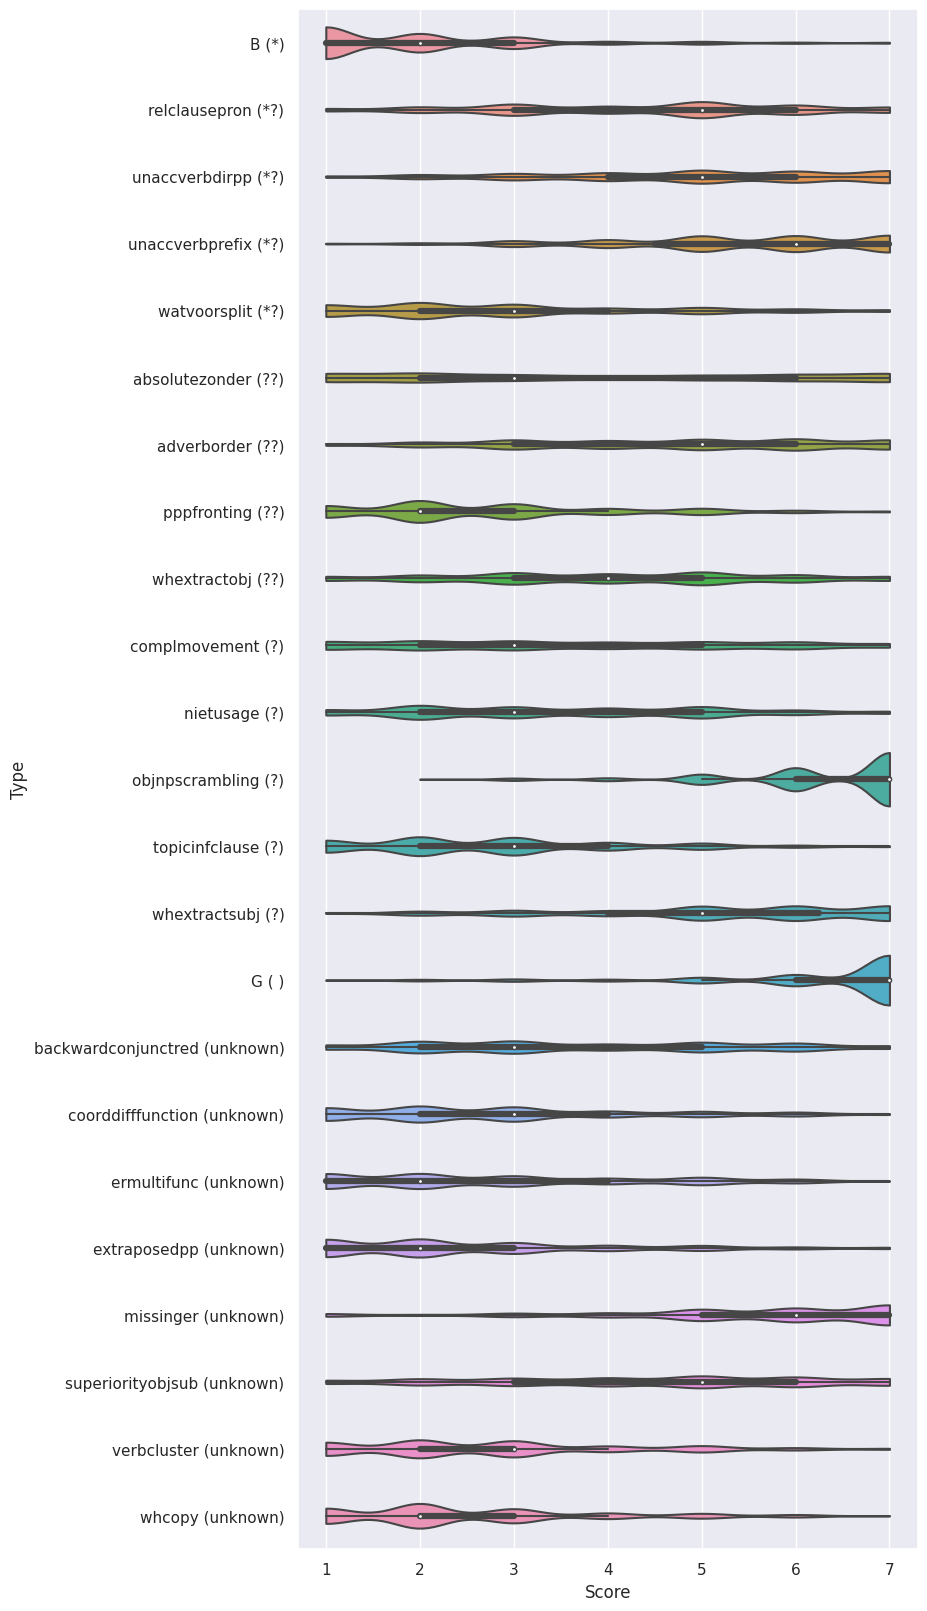

In [27]:
# Per sentence type
sns.set(rc={"figure.figsize":(8, 20)})
print(judgment_sorted_headers['type'].unique())
sns.violinplot(long_df, x='Score', y='Type', cut=0, bw=0.2, order = judgment_sorted_headers['type'].unique())
plt.show()

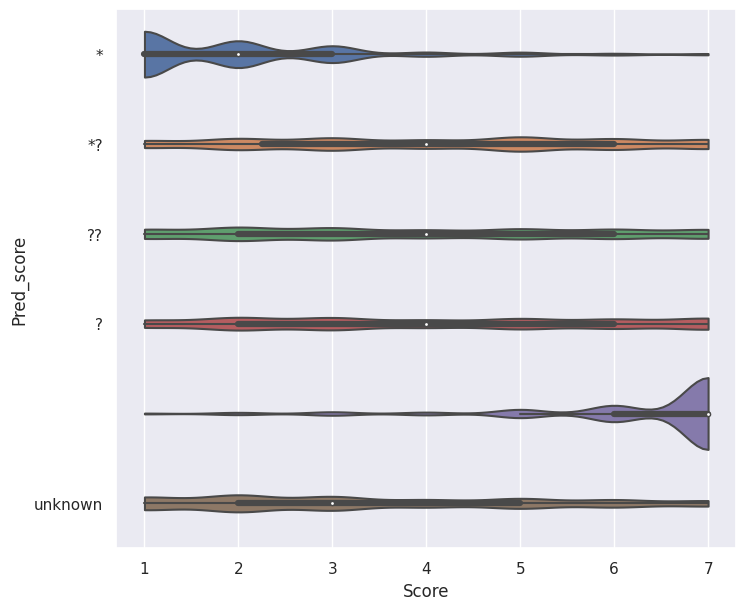

In [28]:
# Per predicted score 
sns.set(rc={"figure.figsize":(8, 7)})
sns.violinplot(long_df, x='Score', y='Pred_score', cut=0, bw=0.2, order=judg_order)
plt.show()


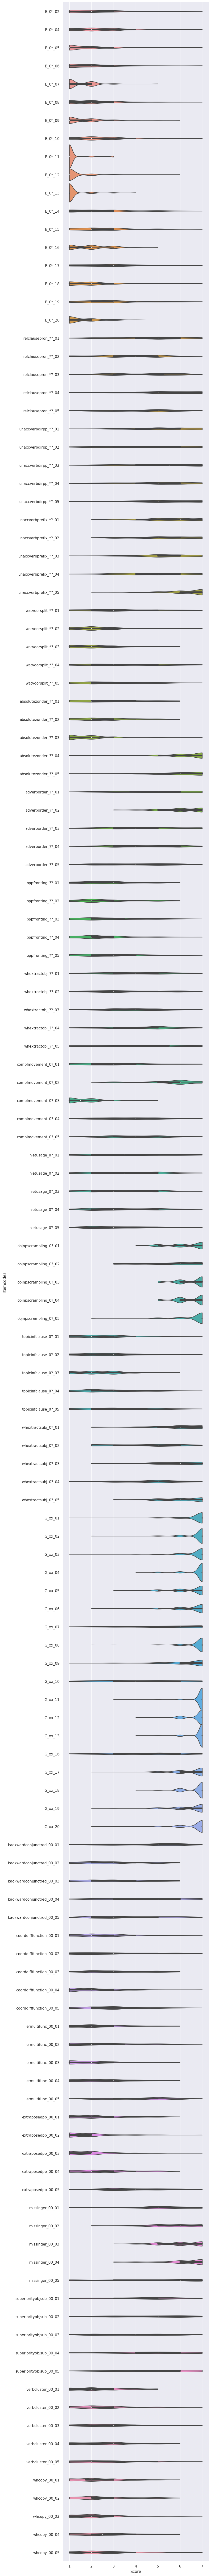

In [29]:
# Per sentence
sns.set(rc={"figure.figsize":(8, len(unique_headers))})
sns.violinplot(long_df, x='Score', y='Itemcodes', cut=0, bw=0.3, width=1.3,order=judgment_sorted_headers['complete'])
plt.show()


Based on the results found in the graphs above, I chose a set of categories to be the final selection. The following code plots that final selection in the order provided. 

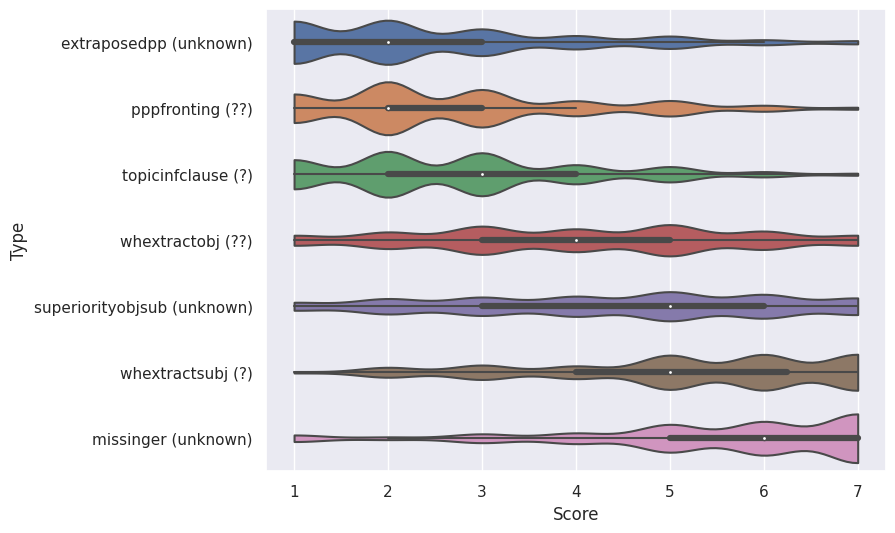

In [30]:
def to_keep_type(df_row, subset_headers):
    return df_row['Type'] in subset_headers

def violin_plot_subset_all(long_df, subset_headers):
    subset_df = long_df[long_df.apply(to_keep_type, subset_headers=subset_headers, axis=1)]
    sns.set(rc={"figure.figsize":(8, 6)})
    #sns.violinplot(long_df, x='Score', y='Type', cut=0, bw=0.2, order = judgment_sorted_headers['type'].unique())
    sns.violinplot(subset_df, x='Score', y='Type', cut=0, bw=0.2, order=subset_headers)
    plt.show()


selected_headers = ['extraposedpp (unknown)', 'pppfronting (??)', 'topicinfclause (?)', 
                    'whextractobj (??)', 'superiorityobjsub (unknown)', 
                    'whextractsubj (?)', 'missinger (unknown)']


violin_plot_subset_all(long_df, selected_headers)


## Split by list
Because we wanted to see if we have different results between the two lists, the following code produces violin plots comparing the two lists. 

In [31]:
def to_keep(df_row, subset_headers):
    return df_row['Itemcodes'] in subset_headers

def violin_plot_subset(long_df, subset_headers, mode='Itemcodes'):
    subset_df = long_df[long_df.apply(to_keep, subset_headers=subset_headers, axis=1)]
    if mode == 'Itemcodes':
        sns.set(rc={"figure.figsize":(8, len(subset_headers))})
        sns.violinplot(subset_df, x='Score', y=mode, hue='List', split=True, inner="quart", linewidth=1, cut=0, bw=0.8, width=0.8,order=judgment_sorted_headers_shared['complete'], palette={"List 1": "b", "List 2": ".85"})
    elif mode == 'Pred_score':
        sns.set(rc={"figure.figsize":(8, 6)})
        sns.violinplot(subset_df, x='Score', y=mode, hue='List', split=True, inner="quart", linewidth=1, cut=0, bw=0.8, width=0.8,order= judg_order[:-1], palette={"List 1": "b", "List 2": ".85"})
    elif mode == 'Type':
        sns.set(rc={"figure.figsize":(8, 6)})
        sns.violinplot(subset_df, x='Score', y=mode, hue='List', split=True, inner="quart", linewidth=1, cut=0, bw=0.8, width=0.8,palette={"List 1": "b", "List 2": ".85"},order=judgment_sorted_headers_shared['type'].unique())
    plt.show()


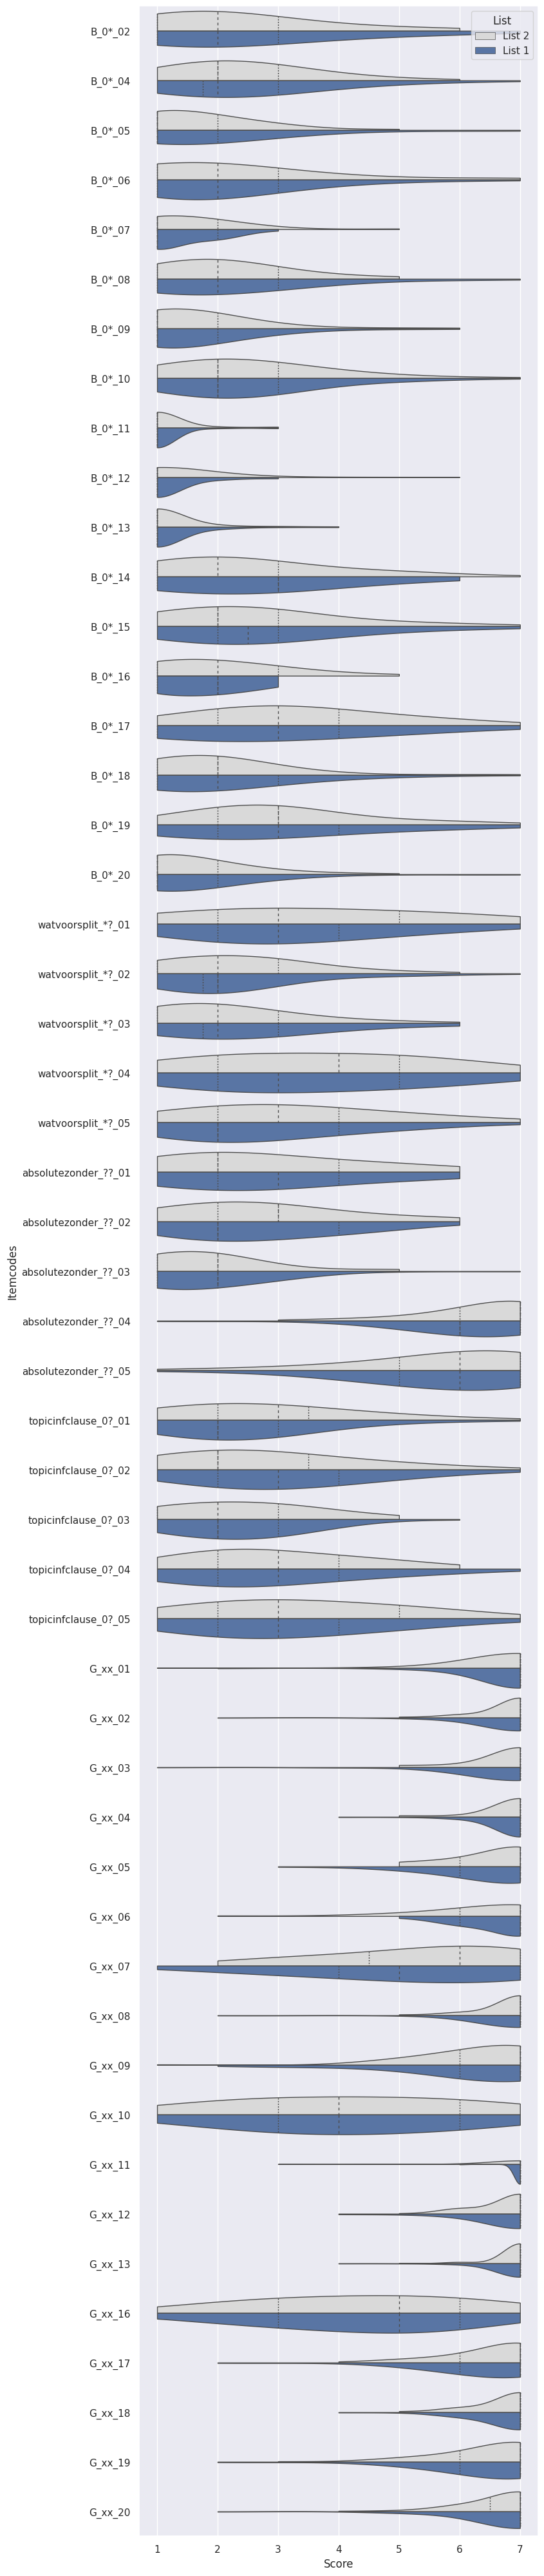

In [32]:
# Per sentence
violin_plot_subset(long_df, shared_headers, mode="Itemcodes")


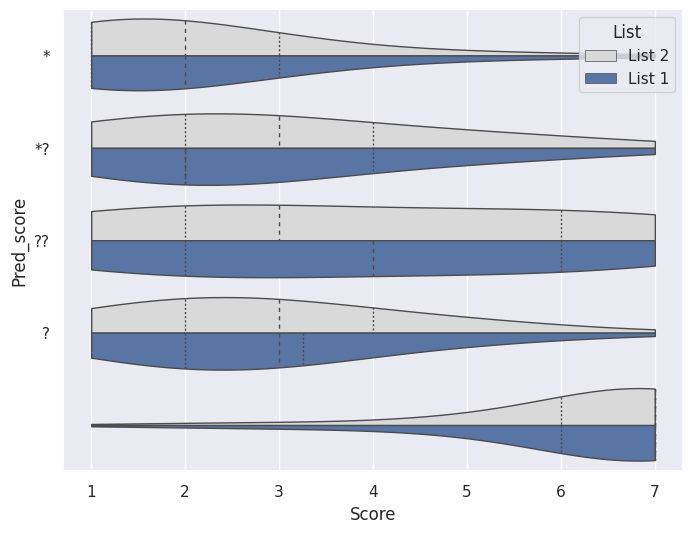

In [33]:
# Per predicted score
violin_plot_subset(long_df, shared_headers, mode="Pred_score")


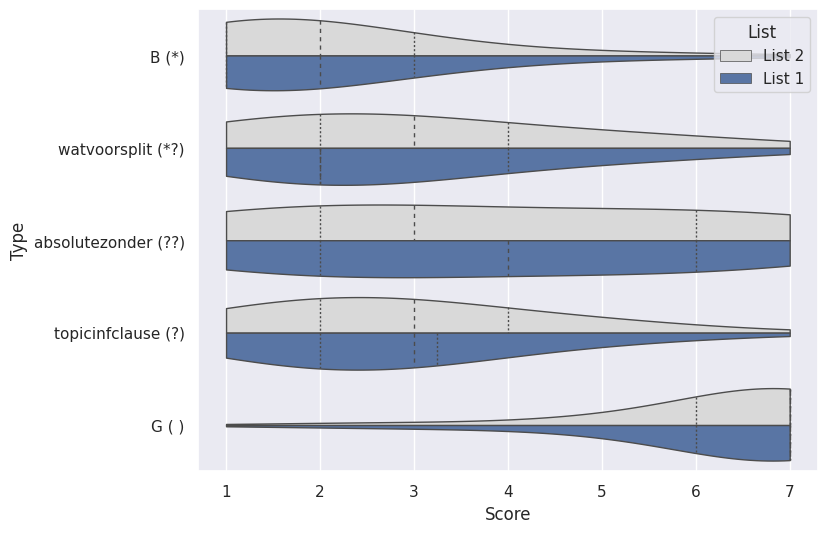

In [34]:
# Per category
violin_plot_subset(long_df, shared_headers, mode="Type")
